<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Run GriddedCCP

In [1]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [2]:
import neuralproc

In [3]:
import submitit
from train_imgs import main, parse_arguments

log_folder="logs/%j"

In [4]:
def repeat_list(l, n):
    return [i for i in l for _ in range(n)]

class Run:
    def checkpoint(self, args):
        """Resubmits the same callable with the same arguments but makes sure continnue from last chckpnt."""
        args.is_continue_train=True 
        return submitit.utils.DelayedSubmission(self, args)
    
    def __call__(self, args):
        job_env = submitit.core.utils.JobEnvironment()
        args.starting_run = args.starting_run * job_env.num_tasks + job_env.local_rank
        return main(args)

In [5]:
datasets_64 = ["zs-mnist"]

Grided_ccp_kwargs = [(f"GridedCCP_varyingk_circular/k{kernel}", f"--n-blocks 5 --kernel-size {kernel} --init-kernel-size 11 --max-epochs 100 --is-circular-padding")
                     for kernel in [1+2*i for i in range(1,9)]]

args_64_ccp = [parse_arguments("GridedCCP {} --starting-run {} --name {} --chckpnt-dirname results/iclr-rebuttals/ {}".format(d, s, name, other).split())
                for s in range(3)
                for d in datasets_64
                for name,other in Grided_ccp_kwargs]


In [6]:
executor_64_ccp=submitit.SlurmExecutor(folder=log_folder, max_num_timeout=3)
executor_64_ccp.update_parameters(num_gpus=1, 
                                   time=60*24,  
                                   cpus_per_task=10, 
                                   mem='32GB',
                                   ntasks_per_node=2
                                  )

In [7]:
job_64_ccp = executor_64_ccp.map_array(Run(), args_64_ccp)

In [8]:
############################################################

In [11]:
job_64_ccp

[SlurmJob<job_id=20009143_0, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_1, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_2, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_3, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_4, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_5, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_6, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_7, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_8, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_9, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_10, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_11, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_12, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_13, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_14, task_id=None, state="RUNNING">,
 SlurmJob<job_id=20009143_15, task_id=None, state="RUNNING">,
 SlurmJob<job_id=2

In [27]:
for j in job_64_ccp:
    print("--------------------------------")
    print(j.stdout())

--------------------------------
submitit INFO (2019-11-09 16:59:00,798) - Starting with JobEnvironment(job_id=20002408_0, hostname=learnfair0266, local_rank=0(2), node=0(1), global_rank=0(2))
submitit INFO (2019-11-09 16:59:00,798) - Loading pickle: /private/home/yannd/projects/Neural-Process-Family/logs/20002408_0/20002408_0_submitted.pkl

--- Training zs-mnist/GridedCCP_varyingk_circular/k3/run_0 ---

  epoch    train_loss    valid_loss    cp       dur
-------  ------------  ------------  ----  --------
      1       -1.1923       -1.2192     +  283.3200
      2       -1.2357       -1.2515     +  282.8922
      3       -1.2630       -1.2797     +  283.1149
      4       -1.2729       -1.2792        283.1963
      5       -1.2822       -1.2843     +  283.0940
      6       -1.2866       -1.2982     +  282.6905
      7       -1.2876       -1.2790        282.6931
      8       -1.2872       -1.3096     +  284.0104
      9       -1.2895       -1.2923        282.2606
     10       -1.289

In [19]:
for j in job_64_ccp:
    print("--------------------------------")
    print(j.stderr())

--------------------------------
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
submitit ERROR (2019-11-09 16:18:24,505) - Submitted job triggered an exception
ERROR:submitit:Submitted job triggered an exception
Traceback (most recent call last):
  File "/private/home/yannd/.conda/envs/assl/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/private/home/yannd/.conda/envs/assl/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/private/home/yannd/.conda/envs/assl/lib/python3.7/site-packages/submitit/core/_submit.py", line 5, in <module>
    submitit_main()
  File "/private/home/yannd/.conda/envs/assl/lib/python3.7/site-packages/submitit/core/submission.py", line 186, in submitit_main
    process_job(args.folder)
  File "/private/home/yannd/.conda/envs/assl/lib/python3.7/site-packages/submitit/core/submission.py", line 179, in process_job
    raise error
  

In [28]:
for j in job_64_ccp:
    j.cancel()

In [10]:
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np

dfs = []
prfx = "results/iclr-rebuttals/zs-mnist/GridedCCP_varyingk_circular/k"
for g in glob(f"{prfx}*/run*/eval.csv"):
    test_loglike = np.loadtxt(g, delimiter=",").mean()
    sffx = g[len(prfx):]
    splitted = sffx.split("/")
    kernel = int(splitted[0])
    receptive_field = 11 + (kernel//2 * 5 *2)
    run = int(splitted[1][len("run_"):])
    dfs.append([receptive_field,run,test_loglike])
    
    
df = pd.DataFrame(dfs,columns=["Size of Receptive Field","run","Test Log Likelihood"])

In [14]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))
  
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch


Autosaving every 600 seconds


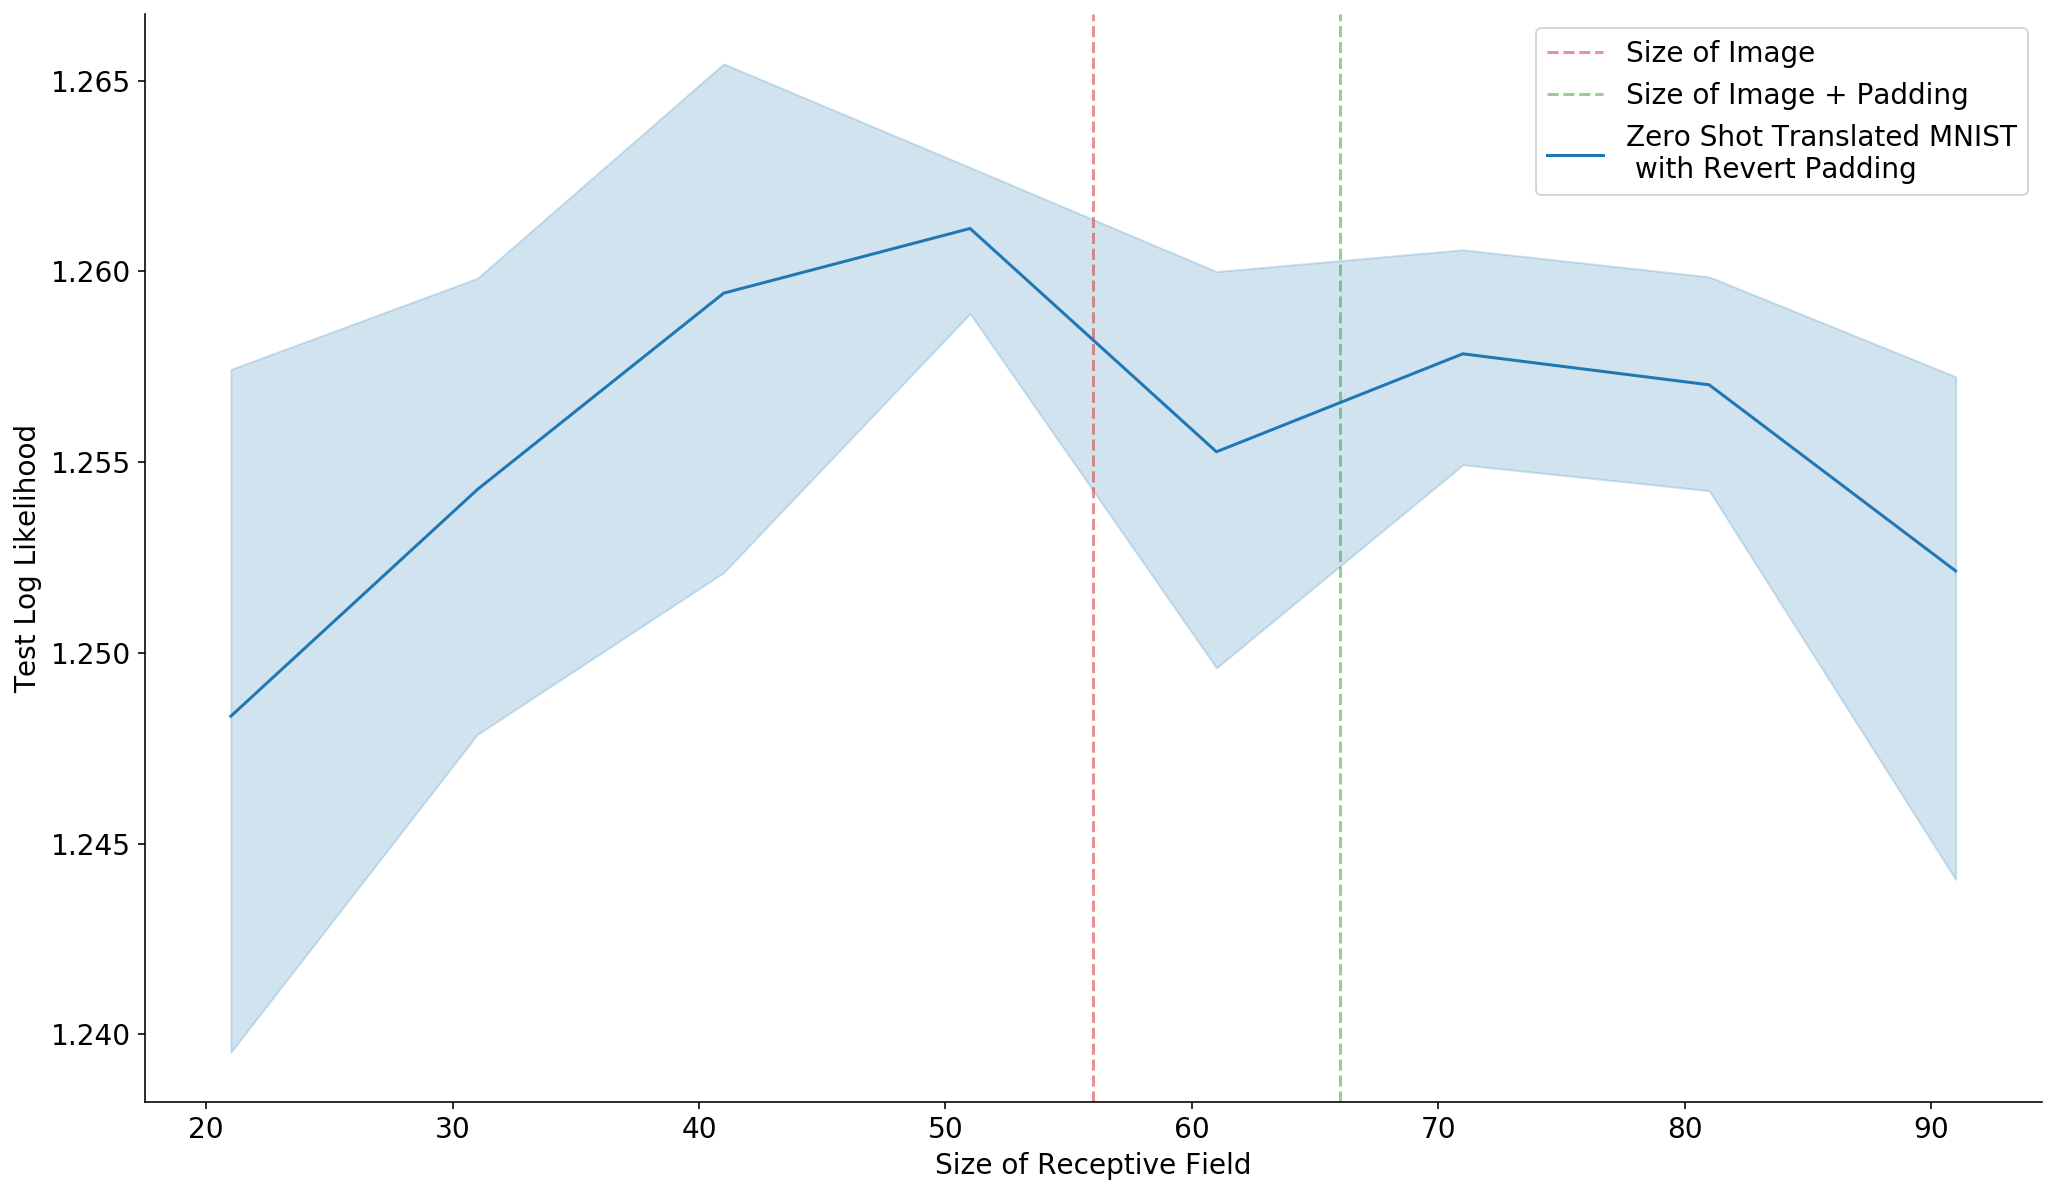

In [23]:
plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1,1,figsize=(17,10))
ax.axvline(56, ls='--', color="tab:red", alpha=0.5, label="Size of Image")
ax.axvline(66, ls='--', color="tab:green", alpha=0.5, label="Size of Image + Padding")
sns.lineplot(x="Size of Receptive Field", y="Test Log Likelihood", data=df, ax=ax, label="Zero Shot Translated MNIST\n with Revert Padding")
sns.despine()

In [18]:
ls results/iclr-rebuttals/zs-multi-mnist/GridedCCP_varyingk_reflected/

GridedCCP_varyingk/           GridedCCP_varyingk_reflected/
GridedCCP_varyingk_circular/


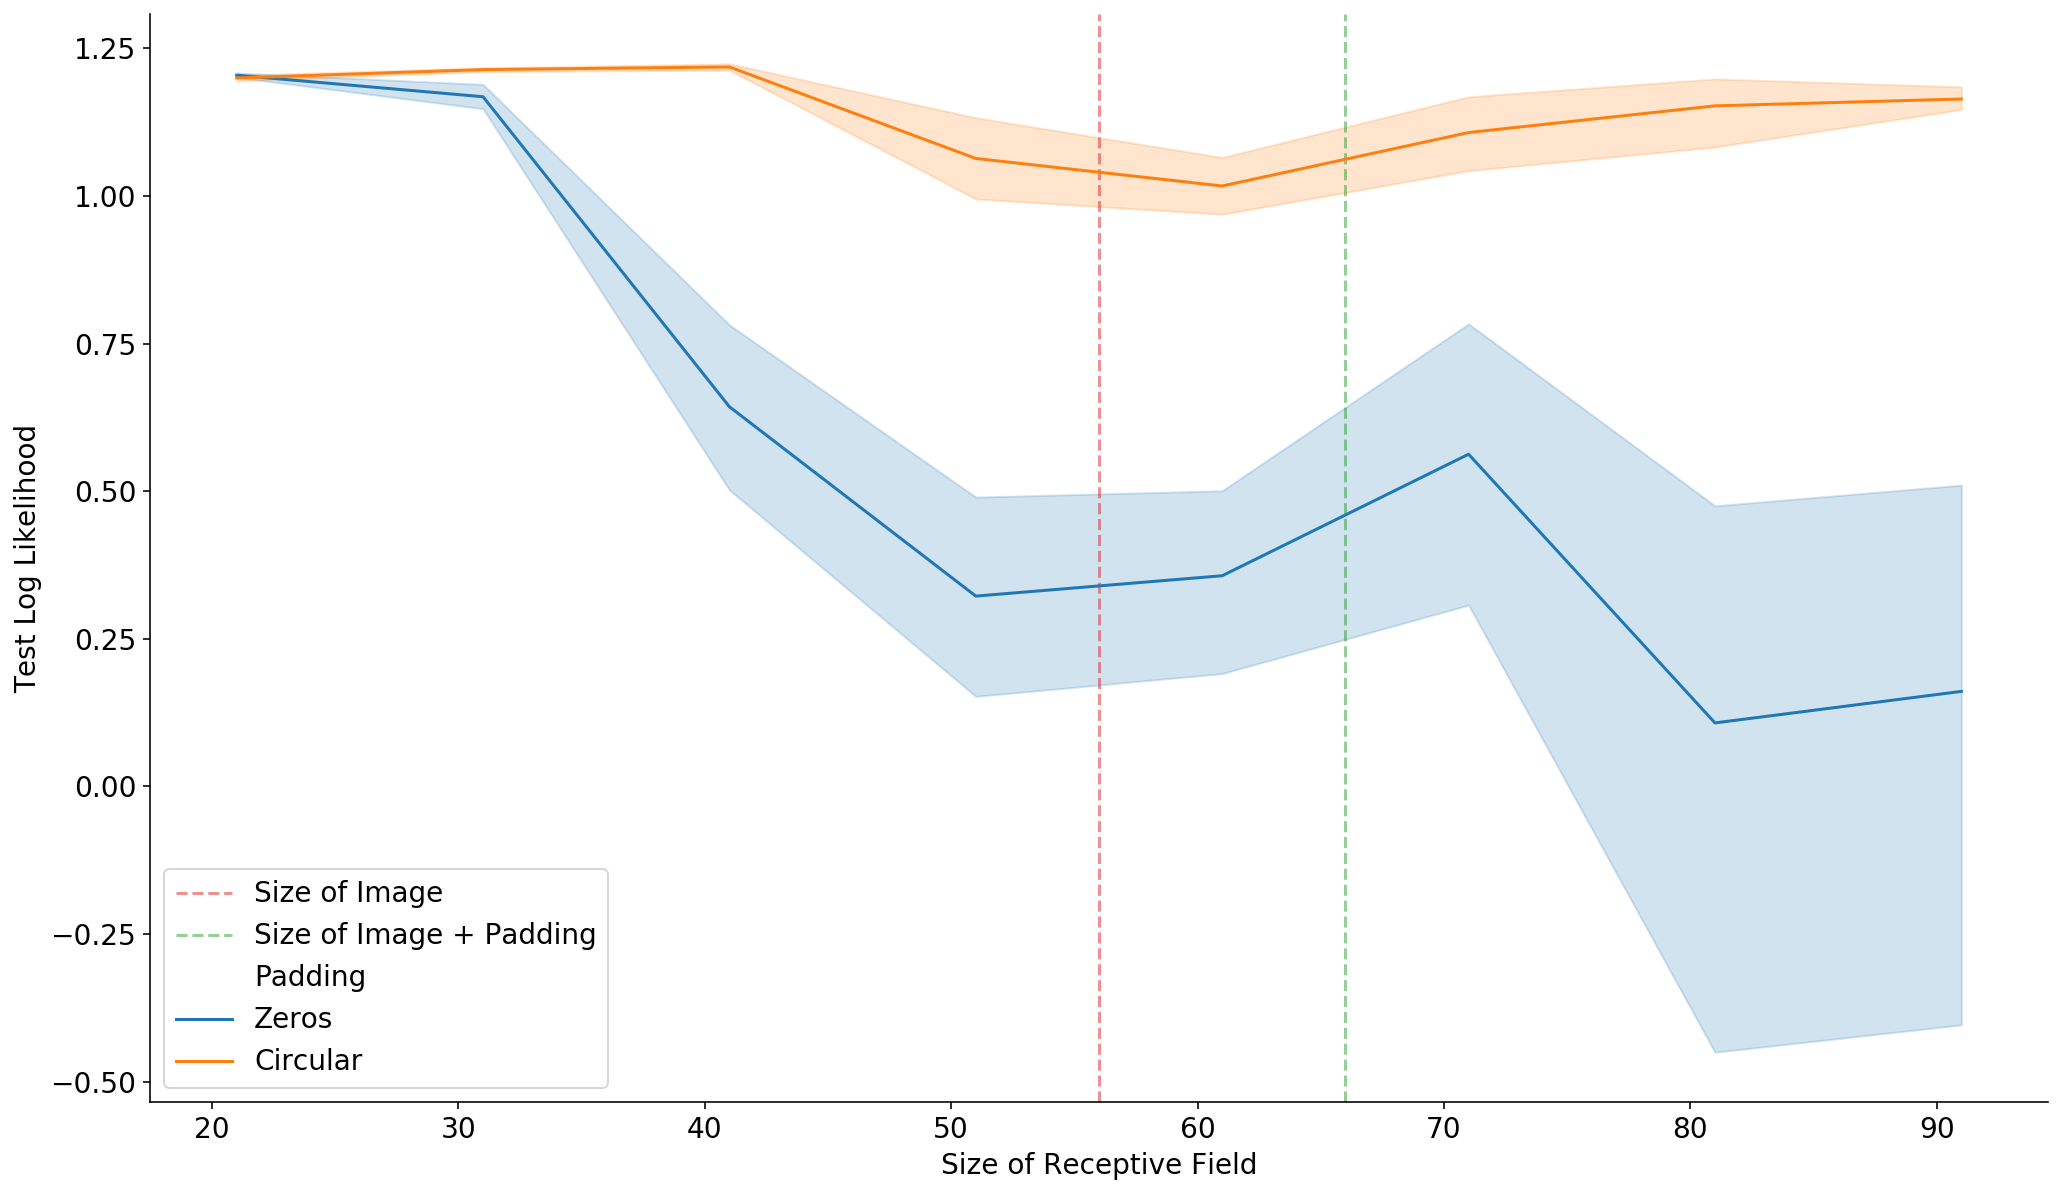

In [21]:
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np

dfs_zs_mmnist = []
prfx = "results/iclr-rebuttals/zs-multi-mnist/GridedCCP_varyingk/k"
for g in glob(f"{prfx}*/run*/eval.csv"):
    test_loglike = np.loadtxt(g, delimiter=",").mean()
    sffx = g[len(prfx):]
    splitted = sffx.split("/")
    kernel = int(splitted[0])
    receptive_field = 11 + (kernel//2 * 5 *2)
    run = int(splitted[1][len("run_"):])
    dfs_zs_mmnist.append(["Zeros",receptive_field,run,test_loglike])
    
dfs_zs_mmnist_refl = []
prfx = "results/iclr-rebuttals/zs-multi-mnist/GridedCCP_varyingk_circular/k"
for g in glob(f"{prfx}*/run*/eval.csv"):
    test_loglike = np.loadtxt(g, delimiter=",").mean()
    sffx = g[len(prfx):]
    splitted = sffx.split("/")
    kernel = int(splitted[0])
    receptive_field = 11 + (kernel//2 * 5 *2)
    run = int(splitted[1][len("run_"):])
    dfs_zs_mmnist_refl.append(["Circular", receptive_field,run,test_loglike])
    
    
    
dfs_zs_mmnist = pd.DataFrame(dfs_zs_mmnist,columns=["Padding","Size of Receptive Field","run","Test Log Likelihood"])
dfs_zs_mmnist_refl = pd.DataFrame(dfs_zs_mmnist_refl,columns=["Padding","Size of Receptive Field","run","Test Log Likelihood"])

df = pd.concat([dfs_zs_mmnist, dfs_zs_mmnist_refl])

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1,1,figsize=(17,10))
ax.axvline(56, ls='--', color="tab:red", alpha=0.5, label="Size of Image")
ax.axvline(66, ls='--', color="tab:green", alpha=0.5, label="Size of Image + Padding")
sns.lineplot(x="Size of Receptive Field", y="Test Log Likelihood", hue="Padding", data=df, ax=ax)
sns.despine()